In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sunraster.instr.spice import read_spice_l2_fits
import h5py
import sunpy 
import sunpy.map
from correct_2d_psf import get_fwd_matrices, correct_spice_raster
from util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from fit_spice_lines import get_overall_center, fit_spice_lines as fsl
import astropy
from astropy.visualization import (ImageNormalize, AsinhStretch)
from astropy import constants as const
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFit2D

from copy import deepcopy
import os
from glob import glob

In [3]:
fit_results = sorted(glob('../sav/test0/*.h5'))
fit_results

['../sav/spice_1024_parameter_scan_core_0.50_wing_0.50.h5',
 '../sav/spice_1024_parameter_scan_core_0.50_wing_1.00.h5',
 '../sav/spice_1024_parameter_scan_core_0.50_wing_1.50.h5',
 '../sav/spice_1024_parameter_scan_core_0.50_wing_2.00.h5',
 '../sav/spice_1024_parameter_scan_core_1.00_wing_0.50.h5',
 '../sav/spice_1024_parameter_scan_core_1.00_wing_1.00.h5',
 '../sav/spice_1024_parameter_scan_core_1.00_wing_1.50.h5',
 '../sav/spice_1024_parameter_scan_core_1.00_wing_2.00.h5',
 '../sav/spice_1024_parameter_scan_core_1.50_wing_0.50.h5',
 '../sav/spice_1024_parameter_scan_core_1.50_wing_1.00.h5',
 '../sav/spice_1024_parameter_scan_core_1.50_wing_1.50.h5',
 '../sav/spice_1024_parameter_scan_core_1.50_wing_2.00.h5',
 '../sav/spice_1024_parameter_scan_core_2.00_wing_0.50.h5',
 '../sav/spice_1024_parameter_scan_core_2.00_wing_1.00.h5',
 '../sav/spice_1024_parameter_scan_core_2.00_wing_1.50.h5',
 '../sav/spice_1024_parameter_scan_core_2.00_wing_2.00.h5']

In [8]:
spice_raster = read_spice_l2_fits("../src/solo_L2_spice-n-ras_20221024T231535_V07_150995398-000.fits")
spice_NeVIII_770_window = spice_raster["Ne VIII 770 - Peak"]

spice_dat = deepcopy(spice_NeVIII_770_window.data[0])
specmin = np.nanmin(spice_NeVIII_770_window.data[0], axis=2)
spice_dat = spice_dat - specmin[:,:,np.newaxis]
spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[12:18,33:40],:,:], axis=0)[np.newaxis,:,:]
rebin_facs = [1,4,1]

spicedat_bindown = bindown(spice_dat[:,120:700,:],np.round(np.array(spice_dat[:,120:700,:].shape)/rebin_facs).astype(np.int32))
spice_dat1 = deepcopy(spicedat_bindown).transpose([2,1,0]).astype(np.float32)
NeVIII_770_window_wvl = spice_NeVIII_770_window.spectral_axis.to_value("Angstrom")

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59876.969164 from DATE-OBS.
Set MJD-BEG to 59876.969164 from DATE-BEG.
Set MJD-AVG to 59877.036108 from DATE-AVG.
Set MJD-END to 59877.103050 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_58621/2941054501.py:5: RuntimeWarning: All-NaN slice encountered
  specmin = np.nanmin(spice_NeVIII_770_window.data[0], axis=2)
/tmp/ipykernel_58621/2941054501.py:7: RuntimeWarning: All-NaN slice encountered
  spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[12:18,33:40],:,:], axis=0)[np.newaxis,:,:]


In [9]:
spice_dat1.shape

(192, 145, 50)

In [10]:
NeVIII_origin_fitmodel = SpectrumFit2D(spice_dat1[:,:,16:30].transpose([1,0,2]).astype(np.float32), NeVIII_770_window_wvl[16:30],
                                line_number=1,line_wvl_init=[770],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
NeVIII_origin_fitmodel.run_lse_mp(prev_init=False,absolute_sigma=False)

/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzh

Doppler velocity corrected by the median of each raster.


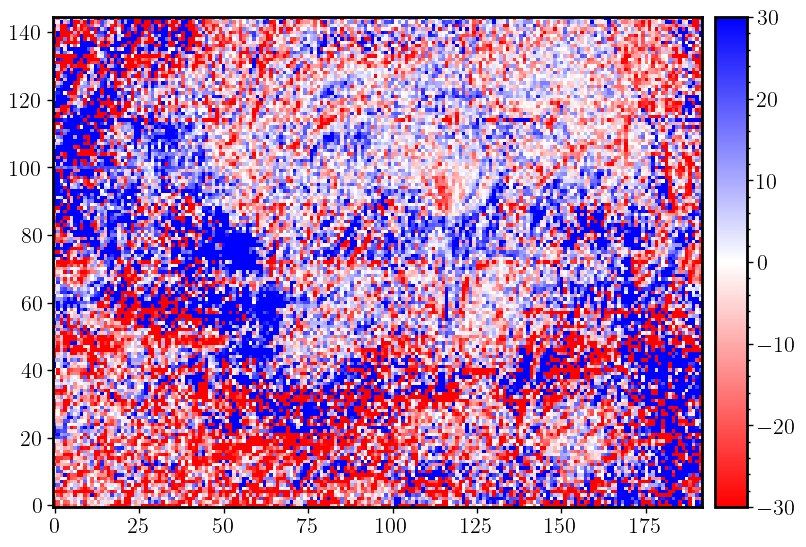

In [12]:
NeVIII_origin_fitmodel.plot_fit2d(param="vel",vmin=-30,vmax=30,vel_corr="column",ref_wvl=770.03,   
                                    aspect=1)

In [63]:
def fit_and_plot(fit_result_file, original_fit_model,save=False):
    with h5py.File(fit_result_file,"r") as hf:
        spice_corr_dat = hf["spice_corr_dat"][:]
        spice_corr_chi2s = hf["spice_corr_chi2s"][:]
        # fwhm_core_yl = hf.attrs["fwhm_core_yl"]
        # fwhm_wing_yl = hf.attrs["fwhm_wing_yl"]


    NeVIII_deconv_rebin_fitmodel = SpectrumFit2D(spice_corr_dat[:,:,16:30].transpose([1,0,2]).astype(np.float32), NeVIII_770_window_wvl[16:30],
                                line_number=1,line_wvl_init=[770],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
    NeVIII_deconv_rebin_fitmodel.run_lse_mp(prev_init=False,absolute_sigma=False)

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8),constrained_layout=True)

    original_fit_model.plot_fit2d(param="int",vmin=0,vmax=10,scale="sqrt",
                                  aspect=1.098,ax=ax1,cmap="sdoaia171",
                                  title="Original")

    NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=10,scale="sqrt",
                                  aspect=1.098,ax=ax2,cmap="sdoaia171",
                                  title="Deconvolved")
    
    ax2.plot(spice_corr_chi2s.T)

    original_fit_model.plot_fit2d(param="vel",vmin=-30,vmax=30,ref_wvl=770.03,   
                                    aspect=1.098,ax=ax3)
    
    NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="vel",vmin=-30,vmax=30,ref_wvl=770.03,   
                                    aspect=1.098,ax=ax4)
    
    fwhm_core_fac = np.float32(os.path.basename(fit_result_file).split("_")[5])
    fwhm_wing_fac = np.float32(os.path.basename(fit_result_file).split("_")[7].split(".h5")[0])

    fwhm_core_yl = fwhm_core_fac*np.array([2, 1.05])
    fwhm_wing_yl = fwhm_wing_fac*np.array([10.0, 2.0])

    
    fig.suptitle("Core: {:.2f}\,arcsec {:.2f}\,\AA\quad Wing: {:.2f}\,arcsec {:.2f}\,\AA".format(*fwhm_core_yl,*fwhm_wing_yl),
                 fontsize=14)

    if save is True:
        plt.savefig(fname=os.path.join("../figs/",os.path.basename(fit_result_file).replace(".h5",".png")),
                    dpi=200)
        fig.clf()
        plt.close()
                    

In [58]:
os.path.basename(fit_results[0]).split("_")[7].split(".h5")[0]

'0.50'

/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


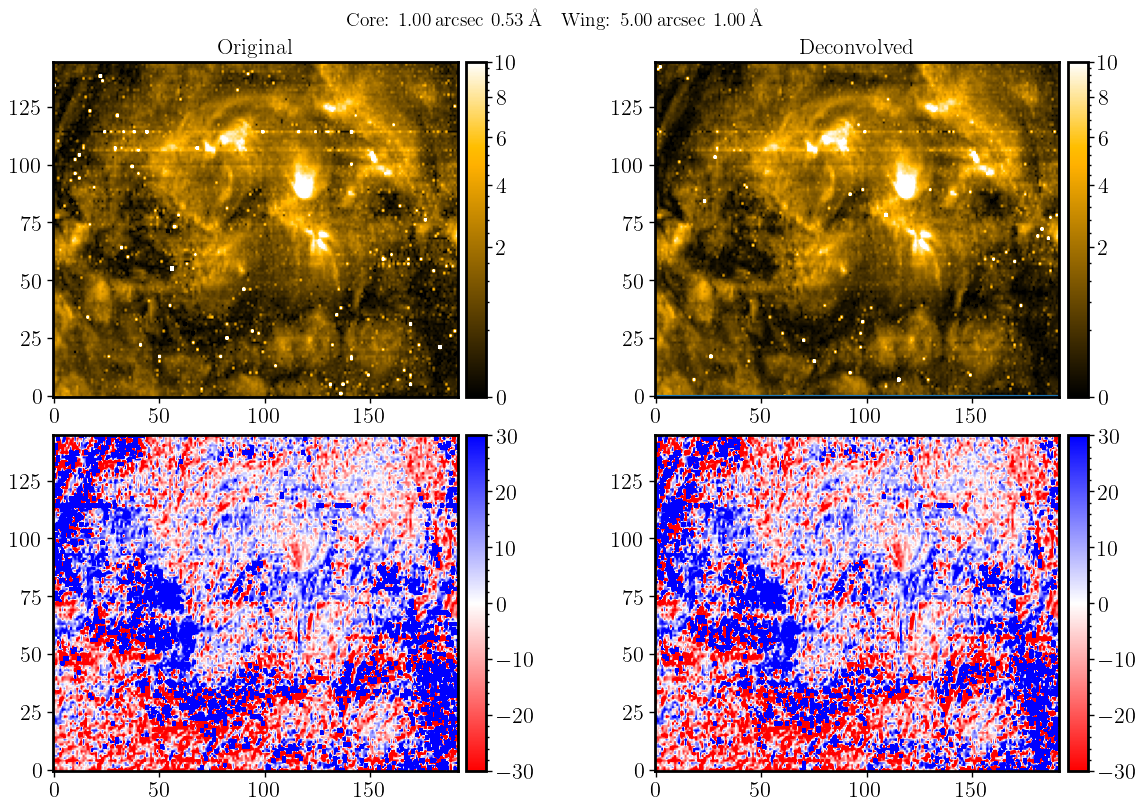

In [64]:
fit_and_plot(fit_results[0],NeVIII_origin_fitmodel)

In [65]:
for fit_result_ in fit_results:
    fit_and_plot(fit_result_,NeVIII_origin_fitmodel,save=True)

/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
